# Genetic Algorithms for Options Strategy Optimization


In [4]:
from tqdm.notebook import trange
import requests as r
from typing import List, Dict, Any, Tuple
from option_history import get_option_chain, get_history
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mibian
from opstrat.helpers import payoff_calculator
from datetime import datetime
today = datetime.now().strftime("%Y%m%d")


def payoff_calculator(x, op_type, strike, op_pr, tr_type, n):
    y = []
    if op_type == 'c':
        for i in range(len(x)):
            y.append(max((x[i]-strike-op_pr), -op_pr))
    else:
        for i in range(len(x)):
            y.append(max(strike-x[i]-op_pr, -op_pr))
    y = np.array(y)

    if tr_type == 's':
        y = -y
    return y*n


def generate_strategy(
        odf,
        margins_df,
        n_options=5,
        quantities=list(range(1, 11)),
        position_types=[
            'buy',
            'sell'
        ],
        lot_size=50,
):
    test_strategy = []

    for _ in range(np.random.randint(1, n_options+1)):  # no of strike prices
        [strike_price, right, ltp_] = odf[
            ['strike_price', 'right', 'ltp']
        ].sample().values[0]
        pos = np.random.choice(position_types)
        qty = np.random.choice(quantities)
        margin = ltp_ * qty * lot_size
        if pos == 'sell':
            margin = margins_df[
                (margins_df['strike_price'] == strike_price) &
                (margins_df['right'] == right)
            ]['span_margin_required'].values[0] * qty

        test_strategy.append((strike_price, pos, right, qty, ltp_, margin))
        trades_columns = ['strike_price', 'action',
                          'right', 'qty', 'ltp', 'funds_required']

        trades_df = pd.DataFrame(test_strategy, columns=trades_columns)
        trades_df.qty = trades_df.action.map(
            {'buy': 1, 'sell': -1}) * trades_df.qty
        trades_df.funds_required = trades_df.action.map(
            {'buy': 1, 'sell': -1}) * trades_df.funds_required
        trades_df = trades_df.groupby(['strike_price', 'right']).agg({
            'qty': 'sum',
            'ltp': 'mean',
            'funds_required': 'sum',
        }).reset_index()
        trades_df['action'] = trades_df.qty.apply(
            lambda x: 'buy' if x > 0 else 'sell')
        trades_df['qty'] = trades_df.qty.abs()
        trades_df['funds_required'] = trades_df.funds_required.abs()

    return trades_df[trades_df['qty'] > 0][trades_columns].to_records(index=False).tolist()


def calculate_margins(odf):
    responses = []

    for row in odf.to_dict('records')[:]:

        resp = r.post(
            'http://localhost:4003/margins',
            json={
                "lists": [{
                    'strike_price': row['strike_price'],
                    'right': row['right'],
                    'expiry_date': row['expiry_date'],
                    'price': row['ltp'],
                    'quantity': 50,
                    "product": "options",
                    'action': 'sell',
                    "stock_code": "NIFTY",
                    "fresh_order_type": "Y",
                }],
                "exchange_code": "NFO",
            },
            headers={
                'content-type': 'application/json',
            }
        ).json()['Success']
        responses.append(resp)

    for row in responses:
        row.update(row['margin_calulation'][0])
        del row['margin_calulation']

    margins_df = pd.DataFrame(responses)
    margins_df[['strike_price', 'span_margin_required']
               ] = margins_df[['strike_price', 'span_margin_required']].astype(float)
    return margins_df


def ltp(df, strike_price, right):
    return df[
        (df['strike_price'] == strike_price) &
        (df['right'] == right)
    ][['ltp', ]].mean(axis=1).round(2).values[0]


def greeks(odf, curr_price, strike_price, days_to_expiry, right):
    volatility = mibian.BS(
        [
            curr_price,
            strike_price,
            0,
            days_to_expiry
        ],
        callPrice=ltp(odf, strike_price, 'Call') if 'call' == right else None,
        putPrice=ltp(odf, strike_price, 'Put') if 'put' == right else None,
    ).impliedVolatility
    option_greeks = mibian.BS(
        [
            curr_price,
            strike_price,
            0,
            days_to_expiry
        ],
        volatility=volatility,
        callPrice=ltp(odf, strike_price, 'Call') if 'call' == right else None,
        putPrice=ltp(odf, strike_price, 'Put') if 'put' == right else None,
    )
    return {
        'delta': option_greeks.callDelta if 'call' == right else option_greeks.putDelta,
        'gamma': option_greeks.gamma,
        'vega': option_greeks.vega,
        'theta': option_greeks.callTheta if 'call' == right else option_greeks.putTheta,
        'rho': option_greeks.callRho if 'call' == right else option_greeks.putRho,
        'volatility': volatility,
    }


def score(spot, row, qvals):
    [q05, q25, q50, q75, q95] = qvals
    _score = 0
    if row['strike_price'] >= spot - q95 and row['strike_price'] <= spot + q95:
        _score += 1
    if row['strike_price'] >= spot - q75 and row['strike_price'] <= spot + q75:
        _score += 1
    if row['strike_price'] >= spot - q50 and row['strike_price'] <= spot + q50:
        _score += 1
    if row['strike_price'] >= spot - q25 and row['strike_price'] <= spot + q25:
        _score += 1
    if row['strike_price'] >= spot - q05 and row['strike_price'] <= spot + q05:
        _score += 1

    return _score/5


def evaluate_strategy(
    strike_range: Tuple[int, int],
    strategies: List[Tuple[float, str, str, int, float, float]],
):

    nifty_range = range(
        int(strike_range[0]),
        int(strike_range[1])
    )
    y = 0
    trade_records = []
    for strike_price, action, right, qty, ltp_, margin in strategies:

        trade_records.append(
            {
                'strike_price': strike_price,
                'action': action,
                'right': right,
                'qty': qty,
                'ltp': ltp_,
                'funds_required': margin,

            }
        )

        points = payoff_calculator(
            nifty_range,
            right[:1].lower(),
            strike_price,
            ltp_,
            action[:1],
            qty
        )
        y += np.array(
            points
        )

    return pd.DataFrame(
        {
            'strike_price': nifty_range,
            'payoff': y,
        }
    ), pd.DataFrame(trade_records)


def fitness(ind, n_range, spot_price, q_vals):
    payoffs, trades_df = evaluate_strategy(
        n_range,
        ind,
    )

    strategy_cost = trades_df.groupby(['strike_price', 'action'])[
        'funds_required'].max().sum()/1e6
    payoffs['score'] = payoffs.apply(lambda x: score(
        spot_price, x, q_vals), axis=1)
    scoring = payoffs.groupby(
        'score')['payoff'].quantile([.05]).unstack() // 20

    profit_scores = scoring.T.values[0].tolist()

    return profit_scores+[strategy_cost, ]


def showcase(strategy, curr_price, q_vals, lower_range, upper_range, lower, higher):
    [q05, q25, q50, q75, q95] = q_vals
    payoffs, trades_df = evaluate_strategy(
        (lower_range, upper_range),
        strategy,
    )

    payoffs['score'] = payoffs.apply(lambda x: score(
        curr_price, x, [q05, q25, q50, q75, q95]), axis=1)

    _, ax = plt.subplots(figsize=(25, 2))

    vis_range = 5
    ax.plot(payoffs.strike_price, payoffs.payoff)
    ax.axvline(curr_price, color='k', linestyle='--', lw=5)

    ax.axvline(curr_price+q05, color='b', linestyle='--', alpha=.95)
    ax.axvline(curr_price-q05, color='b', linestyle='--', alpha=.95)

    ax.axvline(curr_price+q25, color='g', linestyle='--', alpha=.75)
    ax.axvline(curr_price-q25, color='g', linestyle='--', alpha=.75)

    ax.axvline(curr_price+q50, color='y', linestyle='--', alpha=.5)
    ax.axvline(curr_price-q50, color='y', linestyle='--', alpha=.5)

    ax.axvline(curr_price+q75, color='r', linestyle='--', alpha=.25)
    ax.axvline(curr_price-q75, color='r', linestyle='--', alpha=.25)

    ax.axvline(curr_price+q95, color='m', linestyle='--', alpha=.1)
    ax.axvline(curr_price-q95, color='m', linestyle='--', alpha=.1)

    ax.axvspan(curr_price+lower, curr_price + higher, alpha=0.1, color='b')
    # ax.axvspan(curr_price+lower, curr_price + higher, alpha=0.1, color='b')
    ax.axvline(curr_price+vis_range*lower, color='k', linestyle='--')
    ax.axvline(curr_price+vis_range*higher, color='k', linestyle='--')
    ax.axhline(0, color='k', linestyle='--', lw=5)

    ax.set_xlim(lower_range, upper_range)
    plt.show()
    return trades_df


def fetch_live_data(wte=0):
    odf = pd.concat(
        [
            get_option_chain('Call', wte=wte),
            get_option_chain('Put', wte=wte)
        ]
    ).reset_index(drop=True)

    nifty_df = get_history(
        'NIFTY', today, 'NSE',
    )
    nifty_df.datetime = pd.to_datetime(nifty_df.datetime)
    hdf = nifty_df.groupby(
        [
            nifty_df.datetime.dt.date,
            nifty_df.datetime.dt.hour,
        ]
    ).agg(
        {
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
        }
    )

    [lower, higher] = (hdf.open - hdf.close).quantile([.05, .95]).values

    [q05, q25, q50, q75, q95] = (hdf.high - hdf.low).quantile(
        [.05, 0.25, 0.5, 0.75, .95]).values

    curr_price = nifty_df.close.iloc[-1]

    lower_range = int(curr_price - q95)
    upper_range = int(curr_price + q95)

    odf = odf[
        (odf['strike_price'] >= lower_range) &
        (odf['strike_price'] <= upper_range)
    ].reset_index(drop=True)
    margins_df = calculate_margins(odf)
    return curr_price, nifty_df, odf, margins_df, [lower, higher], [lower_range, upper_range], [q05, q25, q50, q75, q95]


def build_distance_matrix(sdf, top_k=1):
    vectors = sdf.values
    vector_distances = []
    for v1 in range(len(vectors)):
        for v2 in range(v1+1, len(vectors)):
            if v1 != v2:
                vector_distances.append({
                    'v1': v1,
                    'v2': v2,
                    'distance': np.linalg.norm(vectors[v1]-vectors[v2])
                })
    dist_df = pd.DataFrame(vector_distances)
    dist_df.sort_values('distance', ascending=False, inplace=True)
    dist_df.reset_index(drop=True, inplace=True)
    return [
        sdf[
            sdf.index.isin(
                dist_df[['v1', 'v2']].values[i].tolist()
            )
        ].sort_values(sdf.columns.tolist(), ascending=False).index[0] for i in range(top_k)
    ]


def generate_candidates(odf, margins_df, n_range,
                        curr_price,
                        q_vals, n_strategies=3):
    [q05, q25, q50, q75, q95] = q_vals
    lower_range, upper_range = n_range
    strategies = [
        generate_strategy(
            odf=odf,
            margins_df=margins_df,
            n_options=5,
            quantities=list(range(1, 2)),
            position_types=['buy', 'sell']
        )for _ in trange(1000)
    ]
    scores = list(
        map(
            lambda strat: fitness(
                strat,
                (lower_range, upper_range),
                curr_price,
                [q05, q25, q50, q75, q95]),
            strategies
        )
    )

    scores_df = pd.DataFrame(scores)
    scores_df.columns = [f's{i}' for i in scores_df.columns][:-1] + ['cost']

    df_cols = scores_df.columns.tolist()
    sort_cols = [False] * (len(scores_df.columns)-1) + [True]
    sdf = scores_df.sort_values(df_cols, ascending=sort_cols)
    indices = build_distance_matrix(sdf, top_k=n_strategies)
    return [strategies[i] for i in indices]

  0%|          | 0/1000 [00:00<?, ?it/s]

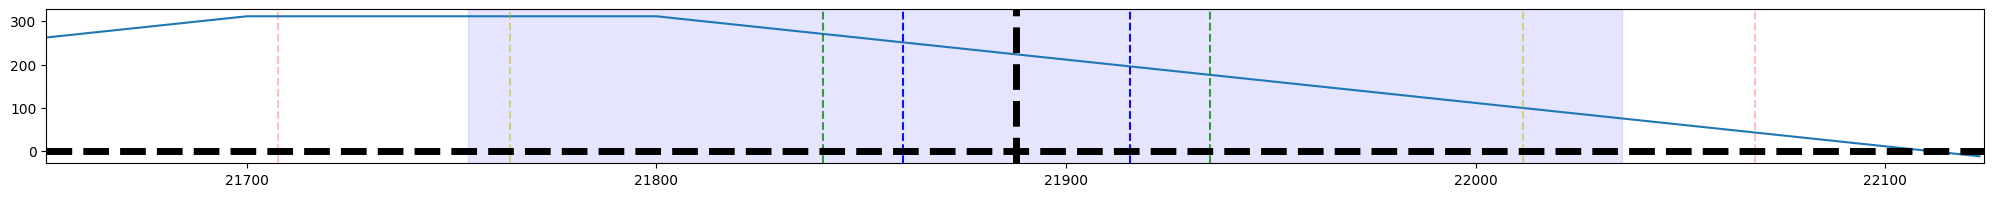

   strike_price action right  qty    ltp  funds_required
0       21700.0   sell  Call    1  310.8       126036.56
1       21800.0   sell   Put    1  100.5       130602.24
2       22100.0   sell   Put    0  246.5       134418.58
-----------------


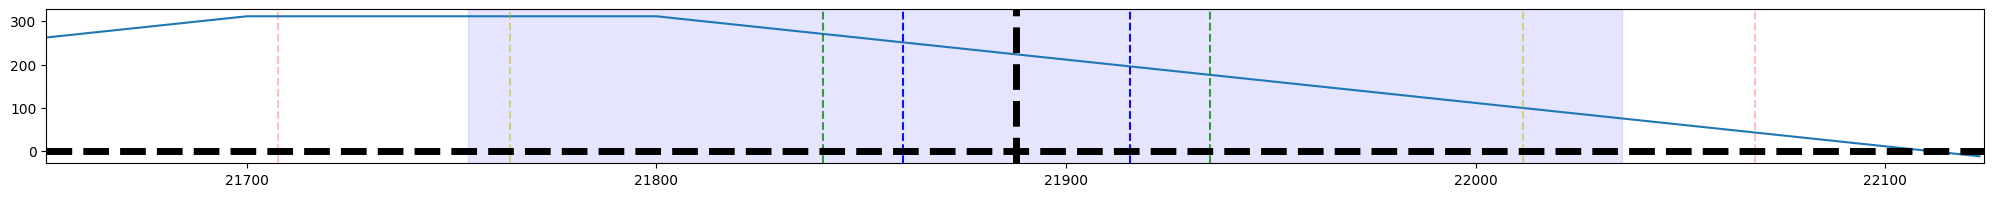

   strike_price action right  qty    ltp  funds_required
0       21700.0   sell  Call    1  310.8       126036.56
1       21800.0   sell   Put    1  100.5       130602.24
2       22100.0   sell   Put    0  246.5       134418.58
-----------------


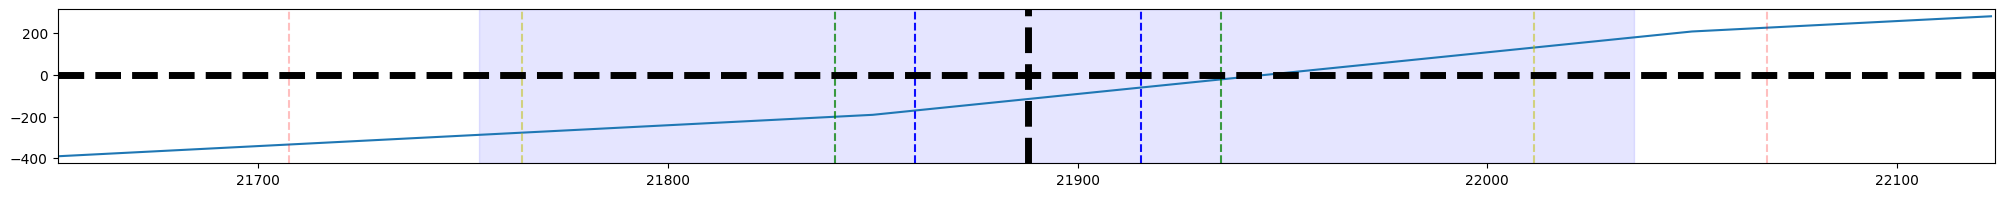

   strike_price action right  qty     ltp  funds_required
0       21850.0    buy  Call    1  208.35        10417.50
1       22050.0   sell   Put    1  216.45       143953.98
-----------------


In [16]:
window_size = 45

(
    curr_price,
    nifty_df,
    odf,
    margins_df,
    [lower, higher],
    [lower_range, upper_range],
    [q05, q25, q50, q75, q95]
) = fetch_live_data(0)

candidates = generate_candidates(
    odf, margins_df, [lower_range, upper_range],
    curr_price, [q05, q25, q50, q75, q95], n_strategies=3
)


for candidate in candidates:
    trades_df = showcase(
        candidate,
        curr_price,
        [q05, q25, q50, q75, q95],
        lower_range,
        upper_range,
        lower,
        higher
    )
    print(trades_df)
    print('-----------------')